# Matching Score Measure (MSM) Confidence Measure

## Stereo Depth Estimation
Stereo depth estimation expoits the parallax (apparent displacement of an object along two different lines of sight) to estimate disparity. Disparity is the difference in horizontal location of an object between the left and right images. The disparity can be used to calculate the real world distance to the object using the formula: 
$$z = \dfrac{fB}{d}$$
,where z is the depth, B is the baseline distance between the two cameras, and d is the disparity. The baseline and focal length is very easy to obtain and is constant, so disparity is the only difficult value to obtain in the equation.

I will be using Heiko Hirschmuller's [semi-global matching](https://core.ac.uk/download/pdf/11134866.pdf) techinque to estimate depth using rectified stereo images. I wont explain how SGM works in this notebook as it would get too long. If you don't know how SGM works, I recommend visiting my notebook [Semi-Global Matching Numpy](https://github.com/ChristianOrr/semi-global-matching-numpy) for a breakdown.

## Confidence Estimation
Disparity estimation algorithms will occasionally perform missmatches, resulting in incorrect disparity values. Confidence estimation helps resolve this issue by providing a confidence estimate for each disparity estimate. Higher confidence values indicate that the disparity estimate is more likely to be accurate. The disparity maps accuracy can be improved by using the confidence estimates to identify and remove false disparity values. 

There are dozens of different confidence measures ranging in speed and accuracy. To learn more about the different types of confidence measures see [On the confidence of stereo matching in a deep-learning era: a quantitative evaluation](https://arxiv.org/abs/2101.00431) by M. Poggi et al.

## Matching Score Measure
We will be implementing a method called [Matching Score Measure (MSM)](http://www.cse.yorku.ca/~wildes/wildesVI02.pdf) by G. Egnal, M. Mintz, and R. Wilde. This is a handcrafted confidence measure designed to be fast. The algorithm will be implemented from scratch in numpy. At the end of the notebook we will review the algorithms ability to identify incorrect disparities. 


In [44]:
import argparse
import sys
import time as t

import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from ipywidgets import interact, widgets

In [45]:
left_name = 'teddy/im2.png' # name (path) to the left image
right_name = 'teddy/im6.png' # name (path) to the right image
left_gt_name = 'teddy/disp2.png' # name (path) to the left ground-truth image
right_gt_name = 'teddy/disp6.png' # name (path) to the right ground-truth image
max_disparity = 64 # maximum disparity for the stereo pair
P1 = 10 # penalty for disparity difference = 1
P2 = 120 # penalty for disparity difference > 1
csize = (5, 5) # size of the kernel for the census transform.
bsize = (3, 3) # size of the kernel for blurring the images and median filtering.
tau = 3 # Used for D1 error rate: number of disparities with difference > tau
conf_threshold = 0.8 # retain disparitys with confidence greater than the conf_threshold

### Load The Images

The images are loaded into grayscale format. We will only be using the intensities of the pixels, so the RGB information is not needed.

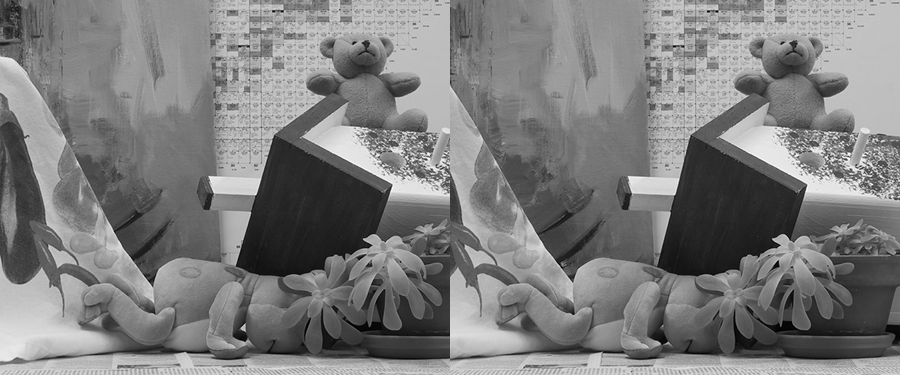

In [46]:
left = cv2.imread(left_name, cv2.IMREAD_GRAYSCALE)
right = cv2.imread(right_name, cv2.IMREAD_GRAYSCALE)

height = left.shape[0]
width = left.shape[1]
assert left.shape[0] == right.shape[0] and left.shape[1] == right.shape[1], 'left & right must have the same shape.'
assert max_disparity > 0, 'maximum disparity must be greater than 0.'

joined_gray = np.concatenate([left, right], axis=1)
display(Image.fromarray(joined_gray))

### Perform Semi-Global Matching

We need to run SGM to extract the aggregation volume. The aggregation volume will then be used to calculate the disparity and extract the confidence estimates. We are using SGM because it is a fast algorithm. However, it's not a requirement to use the confidence measure. We could replace SGM with any other stereo correspondance algorithm if we desired.

In [47]:
def compute_census(left, right, csize, height, width):
    """
    Calculate census bit strings for each pixel in the left and right images.
    Arguments:
        - left: left grayscale image.
        - right: right grayscale image.
        - csize: kernel size for the census transform.
        - height: number of rows of the image.
        - width: number of columns of the image.

    Return: Left and right images with pixel intensities replaced with census bit strings.
    """
    cheight = csize[0]
    cwidth = csize[1]
    y_offset = int(cheight / 2)
    x_offset = int(cwidth / 2)

    left_census_values = np.zeros(shape=(height, width), dtype=np.uint64)
    right_census_values = np.zeros(shape=(height, width), dtype=np.uint64)

    print('\tComputing left and right census...', end='')
    sys.stdout.flush()
    dawn = t.time()
    # offset is used since pixels on the border will have no census values
    for y in range(y_offset, height - y_offset):
        for x in range(x_offset, width - x_offset):
            # left
            center_pixel = left[y, x]
            reference = np.full(shape=(cheight, cwidth), fill_value=center_pixel, dtype=np.int32)
            image = left[(y - y_offset):(y + y_offset + 1), (x - x_offset):(x + x_offset + 1)]
            comparison = image - reference
            # If value is less than center value assign 1 otherwise assign 0 
            left_census_pixel_array = np.where(comparison < 0, 1, 0).flatten()
            # Convert census array to an integer by using bit shift operator
            left_census_pixel = np.int32(left_census_pixel_array.dot(1 << np.arange(cheight * cwidth)[::-1])) 
            left_census_values[y, x] = left_census_pixel

            # right
            center_pixel = right[y, x]
            reference = np.full(shape=(cheight, cwidth), fill_value=center_pixel, dtype=np.int32)
            image = right[(y - y_offset):(y + y_offset + 1), (x - x_offset):(x + x_offset + 1)]
            comparison = image - reference
            # If value is less than center value assign 1 otherwise assign 0 
            right_census_pixel_array = np.where(comparison < 0, 1, 0).flatten()
            # Convert census array to an integer by using bit shift operator
            right_census_pixel = np.int32(right_census_pixel_array.dot(1 << np.arange(cheight * cwidth)[::-1])) 
            right_census_values[y, x] = right_census_pixel

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return left_census_values, right_census_values


def compute_costs(left_census_values, right_census_values, max_disparity, csize, height, width):
    """
    Create cost volume for all potential disparities. 
    Cost volumes for both left and right images are calculated.
    Hamming distance is used to calculate the matching cost between 
    two pixels census values.
    Arguments:
        - left_census_values: left image containing census bit strings for each pixel (in integer form).
        - right_census_values: right image containing census bit strings for each pixel (in integer form).
        - max_disparity: maximum disparity to measure.
        - csize: kernel size for the census transform.
        - height: number of rows of the image.
        - width: number of columns of the image.

    Return: Left and right cost volumes with dimensions H x W x D.
    """
    cwidth = csize[1]
    x_offset = int(cwidth / 2)

    print('\tComputing cost volumes...', end='')
    sys.stdout.flush()
    dawn = t.time()
    left_cost_volume = np.zeros(shape=(height, width, max_disparity), dtype=np.uint32)
    right_cost_volume = np.zeros(shape=(height, width, max_disparity), dtype=np.uint32)
    lcensus = np.zeros(shape=(height, width), dtype=np.int32)
    rcensus = np.zeros(shape=(height, width), dtype=np.int32)

    for d in range(0, max_disparity):
        # The right image is shifted d pixels accross
        rcensus[:, (x_offset + d):(width - x_offset)] = right_census_values[:, x_offset:(width - d - x_offset)]
        # 1 is assigned when the bits differ and 0 when they are the same
        left_xor = np.int32(np.bitwise_xor(np.int32(left_census_values), rcensus))
        # All the 1's are summed up to give us the number of different pixels (the cost)
        left_distance = np.zeros(shape=(height, width), dtype=np.uint32)
        while not np.all(left_xor == 0):
            tmp = left_xor - 1
            mask = left_xor != 0
            left_xor[mask] = np.bitwise_and(left_xor[mask], tmp[mask])
            left_distance[mask] = left_distance[mask] + 1
        # All the costs for that disparity are added to the cost volume
        left_cost_volume[:, :, d] = left_distance

        # The left image is shifted d pixels accross
        lcensus[:, x_offset:(width - d - x_offset)] = left_census_values[:, (x_offset + d):(width - x_offset)]
        # 1 is assigned when the bits differ and 0 when they are the same
        right_xor = np.int32(np.bitwise_xor(np.int32(right_census_values), lcensus))
        # All the 1's are summed up to give us the number of different pixels (the cost)
        right_distance = np.zeros(shape=(height, width), dtype=np.uint32)
        while not np.all(right_xor == 0):
            tmp = right_xor - 1
            mask = right_xor != 0
            right_xor[mask] = np.bitwise_and(right_xor[mask], tmp[mask])
            right_distance[mask] = right_distance[mask] + 1
        # All the costs for that disparity are added to the cost volume
        right_cost_volume[:, :, d] = right_distance

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return left_cost_volume, right_cost_volume


def get_path_cost(slice, offset, penalties, other_dim, disparity_dim):
    """
    Calculates the minimum costs for all potential disparities of 
    the pixels along a single path direction.
    Arguments:
        - slice: Array containing costs for all disparities, D, 
            along a direction, M, with dimension M x D
        - offset: Number of pixels on the border to ignore.
        - penalties: Matrix containing the penalties to assign to the 
            previous disparities costs. For previous disparities that differ 
            from current disparities. 
        - other_dim: Number of pixels in the current paths direction.
        - disparity_dim: Number of disparities to calculate minimum costs.

    Returns: The pixels minimum costs for all disparities, D, 
        along path direction, M, with shape M x D.
    """
    minimum_cost_path = np.zeros(shape=(other_dim, disparity_dim), dtype=np.uint32)
    minimum_cost_path[offset - 1, :] = slice[offset - 1, :]

    for pixel_index in range(offset, other_dim):
        # Get all the minimum disparities costs from the previous pixel in the path
        previous_cost = minimum_cost_path[pixel_index - 1, :]
        # Get all the disparities costs (from the cost volume) for the current pixel
        current_cost = slice[pixel_index, :]
        costs = np.repeat(previous_cost, repeats=disparity_dim, axis=0).reshape(disparity_dim, disparity_dim)
        # Add penalties to the previous pixels disparities that differ from current pixels disparities
        costs = costs + penalties
        # Find minimum costs for the current pixels disparities using the previous disparities costs + penalties 
        costs = np.amin(costs, axis=0)  
        # Current pixels disparities costs + minimum previous pixel disparities costs (with penalty) - 
        # (constant term) minimum previous cost from all disparities 
        pixel_direction_costs = current_cost + costs - np.amin(previous_cost)
        minimum_cost_path[pixel_index, :] = pixel_direction_costs

    return minimum_cost_path 
    

def get_penalties(max_disparity, P2, P1):
    """
    Creates a matrix of all the potential penalties for matching
    a current disparity (represented by the column index), with 
    a previous disparity (represented by the row index).
    Arguments:
        - max_disparity: Maximum disparity of the array.
        - P2: Penalty for disparity difference > 1
        - P1: Penalty for disparity difference = 1
    
    Return: Matrix containing all the penalties when disparity d1 from a column
            is matched with a previous disparity d2 from the row.
    """
    p2 = np.full(shape=(max_disparity, max_disparity), fill_value=P2, dtype=np.uint32)
    p1 = np.full(shape=(max_disparity, max_disparity), fill_value=P1 - P2, dtype=np.uint32)
    p1 = np.tril(p1, k=1) # keep values lower than k'th diagonal
    p1 = np.triu(p1, k=-1) # keep values higher than k'th diagonal
    no_penalty = np.identity(max_disparity, dtype=np.uint32) * -P1 # create diagonal matrix with values -p1
    penalties = p1 + p2 + no_penalty
    return penalties


def aggregate_costs(cost_volume, P2, P1, height, width, disparities):
    """
    Calculates the pixels costs for all disparities along all paths (4 in this case).

    Arguments: 
        - cost_volume: Array containing the matching cost for each pixel at each disparity.
        - P2: Penalty for disparity difference > 1
        - P1: Penalty for disparity difference = 1
        - height: Number of rows of the image.
        - width: Number of columns of the image.
        - disparities: Number of disparities to calculate minimum matching costs.

    Returns: Array containing the pixels matching costs for all disparities along 
        all directions, with dimension H x W x D X 4.
    """
    sys.stdout.flush()
    dawn = t.time()

    penalties = get_penalties(disparities, P2, P1)

    print("\tProcessing North and South aggregation...")
    south_aggregation = np.zeros(shape=(height, width, disparities), dtype=np.uint32)
    north_aggregation = np.copy(south_aggregation)

    for x in range(0, width):
        # Takes all the rows and disparities for a single column
        south = cost_volume[:, x, :]
        # Invert the rows to get the opposite direction
        north = np.flip(south, axis=0)
        south_aggregation[:, x, :] = get_path_cost(south, 1, penalties, height, disparities)
        north_aggregation[:, x, :] = np.flip(get_path_cost(north, 1, penalties, height, disparities), axis=0)


    print("\tProcessing East and West aggregation...", end='')
    east_aggregation = np.copy(south_aggregation)
    west_aggregation = np.copy(south_aggregation)
    for y in range(0, height):
        # Takes all the column and disparities for a single row
        east = cost_volume[y, :, :]
        # Invert the columns to get the opposite direction
        west = np.flip(east, axis=0)
        east_aggregation[y, :, :] = get_path_cost(east, 1, penalties, width, disparities)
        west_aggregation[y, :, :] = np.flip(get_path_cost(west, 1, penalties, width, disparities), axis=0)

    # Combine the costs from all paths into a single aggregation volume
    aggregation_volume = np.concatenate((south_aggregation[..., None], north_aggregation[..., None], east_aggregation[..., None], west_aggregation[..., None]), axis=3)

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return aggregation_volume


def sgm(left, right, max_disparity, P1, P2, csize, bsize):

    print("Performing Gaussian blur on the images...")
    left = cv2.GaussianBlur(left, bsize, 0, 0)
    right = cv2.GaussianBlur(right, bsize, 0, 0)

    print('\nStarting cost computation...')
    left_census, right_census = compute_census(left, right, csize, height, width)
    left_cost_volume, right_cost_volume = compute_costs(left_census, right_census, max_disparity, csize, height, width)


    print('\nStarting left aggregation computation...')
    left_aggregation_volume = aggregate_costs(left_cost_volume, P2, P1, height, width, max_disparity)
    print('\nStarting right aggregation computation...')
    right_aggregation_volume = aggregate_costs(right_cost_volume, P2, P1, height, width, max_disparity)


    return left_aggregation_volume, right_aggregation_volume

In [48]:
left_aggregation_volume, right_aggregation_volume = sgm(left, right, max_disparity, P1, P2, csize, bsize)

Performing Gaussian blur on the images...

Starting cost computation...
	Computing left and right census...	(done in 3.57s)
	Computing cost volumes...	(done in 5.66s)

Starting left aggregation computation...
	Processing North and South aggregation...
	Processing East and West aggregation...	(done in 16.78s)

Starting right aggregation computation...
	Processing North and South aggregation...
	Processing East and West aggregation...	(done in 17.15s)


### Display Disparities

Now we can use the aggregation volumes to extract the disparity maps and compare them to the groundtruth.

In [49]:
def normalize(disp, max_disparity):
    """
    Normalizes the disparity map, then
    quantizes it so that it can be displayed. 
    Arguments:
        - disp: disparity map with dimensions H x W.
        - max_disparity: maximum disparity of the array.
    
    Return: normalized then quantized array, ready for visualization.
    """
    return 255.0 * disp / max_disparity


def select_disparity(aggregation_volume):
    """
    Converts the aggregation volume into a disparity map using 
    the winner takes all strategy. 
    Cost volume is first calculated by taking the sum of the costs over all paths.
    Then the disparities are determined by finding the 
    disparity index with the lowest cost for the pixel.

    Arguments:
        - aggregation_volume: Array containing the matching costs for 
            all pixels at all disparities and paths, with dimension H x W x D x N

    Returns: Disparity map with dimensions H x W.
    """
    # sum up costs for all directions
    volume = np.sum(aggregation_volume, axis=3) 
    # returns the disparity index with the minimum cost associated with each h x w pixel
    disparity_map = np.argmin(volume, axis=2) 
    return disparity_map


def colorize_image(image, cmap='jet'):
    """
    Converts single channel matrix with quantized values
    to an RGB colorized version.
    Arguments:
      - image: Quantized (uint8) single channel image with dimensions H x W 
      - cmap: a valid cmap named for use with matplotlib's 'get_cmap'
    
    Returns an RGB depth map with dimension H x W x 3.
    """
    color_map = cm.get_cmap(cmap)
    colors = color_map(np.arange(256))[:, :3].astype(np.float32)
    colorized_map = np.take(colors, image, axis=0)
    colorized_map = np.uint8(colorized_map * 255)
    return colorized_map


Selecting best disparities...

Applying median filter...


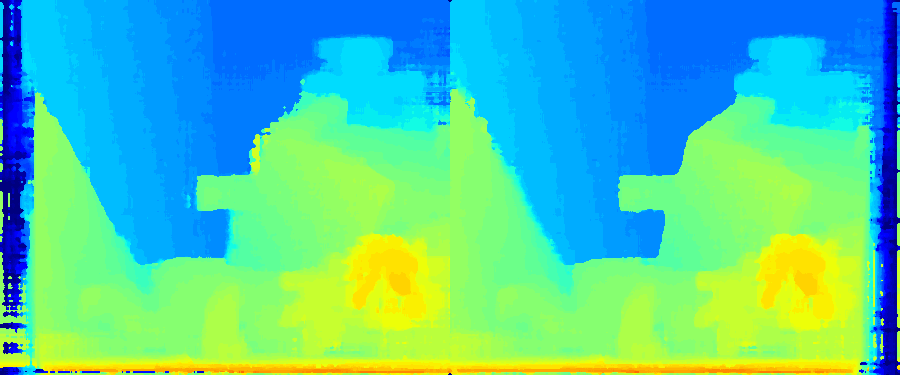

In [50]:
print('\nSelecting best disparities...')
left_disparity_map = np.uint8(normalize(select_disparity(left_aggregation_volume), max_disparity))
right_disparity_map = np.uint8(normalize(select_disparity(right_aggregation_volume), max_disparity))
print('\nApplying median filter...')
left_disparity_map = cv2.medianBlur(left_disparity_map, bsize[0])
right_disparity_map = cv2.medianBlur(right_disparity_map, bsize[0])


left_depth_map = colorize_image(left_disparity_map)
right_depth_map = colorize_image(right_disparity_map)

joined_depth_map = np.concatenate([left_depth_map, right_depth_map], axis=1)
display(Image.fromarray(joined_depth_map))

### Display Groundtruth Disparities

The SGM disparity is not far off from the groundtruth shown below, but it performs poorly near the edges of the objects. We will in the next section if the MSM confidence measure can identify these incorrect disparities.

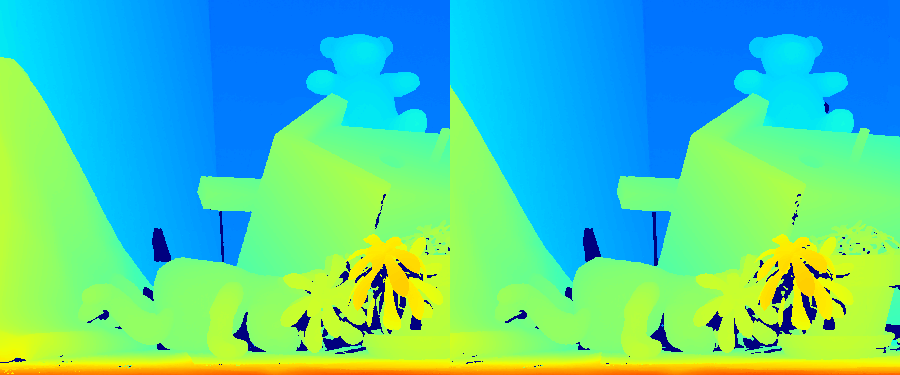

In [51]:
left_gt = cv2.imread(left_gt_name, cv2.IMREAD_GRAYSCALE)
right_gt = cv2.imread(right_gt_name, cv2.IMREAD_GRAYSCALE)

left_depth_map_gt = colorize_image(left_gt)
right_depth_map_gt = colorize_image(right_gt)

joined_depth_map_gt = np.concatenate([left_depth_map_gt, right_depth_map_gt], axis=1)
display(Image.fromarray(joined_depth_map_gt))

### MSM Algorithm Explanation

Now its time to create the MSM algorithm. We start by converting the aggregation volume into a single cost volume. Each pixel in the cost volume will have a cost curve. The cost curve is a sequence of matching costs for each disparity. MSM works by negating the minimum cost value in the cost curve. The cost's represent how good the match was at that disparity, so higher cost means worse match and lower cost means a better match. The idea behind MSM is that the minimum cost in the cost curve is inversely proportional to the confidence of the disparity estimate. Hence, we can take the negative of the minimum cost value, which provide a low confidence value when the minmium cost is high and a high confidence value when the minimum cost is low.  

### Cost Curve Example
An Example of a cost curve from [On the confidence of stereo matching in a deep-learning era: a quantitative evaluation](https://arxiv.org/abs/2101.00431) by M. Poggi et al. is shown below. $d_1$ is the minimum cost in the cost curve. Its cost value is 0.1. Using MSM, its confidence would be -0.1. This is then normalized to get a convenient value between 0-1.

![Cost Curve Example](./figures/cost-curve-example.png)

### MSM Equation
The MSM confidence estimation equation is given by:
$$MSM(p) = -C_{d_1}(p)$$ 
, where $C_{d_1}(p)$ is the cost at position $d_1$, $p$ is the pixel and $d_1$ is the disparity with minimum cost in the cost curve.


In [52]:
def matching_score_measure(aggregation_volume, csize):
    """
    Creates a confidence map (H x W) using the 
    matching score measure technique from the 
    aggregation volume (H x W x D x N).

    Arguments:
        - aggregation_volume: Array containing the matching costs for 
            all pixels at all disparities and paths, with dimension H x W x D x N.
        - csize: kernel size for the census transform.

    Returns: Confidence map with normalized values (0-1) and 
        dimensions H x W.
    """
    # sum up costs for all directions
    volume = np.sum(aggregation_volume, axis=3, dtype=np.int32)     
    # returns the minimum cost associated with each h x w pixel
    min_costs = np.min(volume, axis=2) 
    # Negate the cost so that lower is less confidant and higher is more confident
    min_costs = -min_costs
    # Normalize to get confidence values between 0-1
    minimum = np.min(min_costs)
    maximum = np.max(min_costs)
    confidence = (min_costs - minimum) / (maximum - minimum)
    # Set border pixels confidence to 0 (since disparity couldn't be calculated there)
    confidence[:csize[0], :] = 0 # top border
    confidence[-csize[0]:, :] = 0 # bottom border
    confidence[:, :csize[1]] = 0 # left border
    confidence[:, -csize[1]:] = 0 # right border
    return confidence

### Plot Confidence Maps

We will now plot the confidence maps by quantizing their values. The confidences are colorized using the winter color map to make the confidence differences easier to see. Dark blue represents low confidence and light green represents high confidence. The disparity maps shown previously displayed low accuracy around the edges of the objects, the confidence maps below have done a good job at identified these regions.


Calculating confidences...


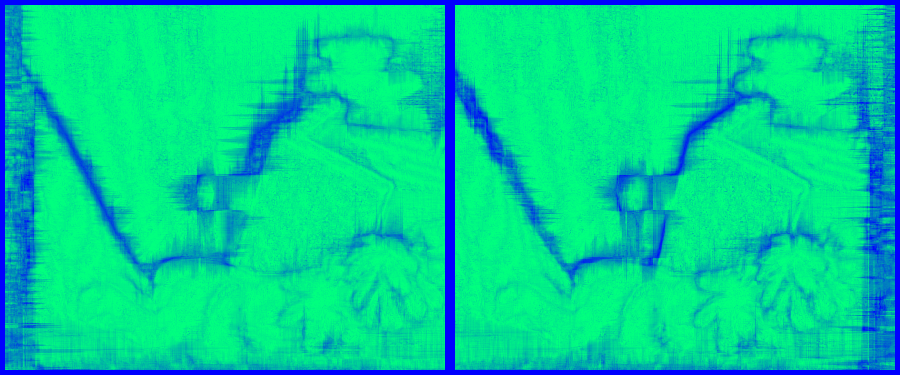

In [53]:
print("\nCalculating confidences...")
left_confidences = matching_score_measure(left_aggregation_volume, csize)
right_confidences = matching_score_measure(right_aggregation_volume, csize)

joined_confidences = np.concatenate([
    colorize_image(np.uint8(left_confidences * 255), "winter"), 
    colorize_image(np.uint8(right_confidences * 255), "winter")], axis=1)
display(Image.fromarray(joined_confidences))

### Filter Low Confidence Disparities

We can achieve a more accurate disparity map by using the condifence maps to remove the low confidence disparities, as shown below. The confidence threshold can be set to any value between 0-1, with higher values retaining the most confident disparities. Higher thresholds come at the cost of a more sparse disparity map, so its not always better to use a higher confidence threshold. The ideal threshold value will depend on the use case and on the accuracy of the confidence estimator at the different confidence levels, which we will explore in the next section.

In [54]:
def filter_disparity(disp, conf, threshold):
    filtered_conf = np.where(conf >= threshold, disp, 0)
    return filtered_conf

In [55]:
def update(threshold = 0.8):
    left_filtered_disp = filter_disparity(left_disparity_map, left_confidences, threshold)
    right_filtered_disp = filter_disparity(right_disparity_map, right_confidences, threshold)

    joined_filtered_disp = np.concatenate([
        colorize_image(left_filtered_disp, "jet"), 
        colorize_image(right_filtered_disp, "jet")], axis=1)
    display(Image.fromarray(joined_filtered_disp))

interact(update, threshold = widgets.FloatSlider(min = 0, max = 1.0, step = 0.05, value = conf_threshold))

interactive(children=(FloatSlider(value=0.8, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

<function __main__.update(threshold=0.8)>

### Evaluate Confidence Measure

In [56]:
def calc_roc(disp, gt, conf, tau):


    # Don't use pixels lacking ground truth disparity
    valid = gt > 0
    disp = disp[valid]
    gt = gt[valid]
    conf = conf[valid]

    # Sort the disparities based on decreasing order of confidence
    sorted_indices = np.argsort(conf)[::-1]
    sorted_disp = np.take_along_axis(disp, sorted_indices, axis=0)
    sorted_gt = np.take_along_axis(gt, sorted_indices, axis=0)
    sorted_conf = np.take_along_axis(conf, sorted_indices, axis=0)  

    # Get the errors (disparities with greater absolute difference than tau)
    errors = np.where(np.abs(sorted_disp - sorted_gt) > tau, 1, 0) 
    # Get the mean error rate on all pixels
    mean_error = np.sum(errors) / errors.shape[0]

    # Find the cumulitive ratios of data to calculate errors for the roc curve
    step_size = 0.05
    cumulitive_ratio = 0
    ratio_pixels = []
    while cumulitive_ratio < 1.0:
        cumulitive_ratio += step_size
        ratio_pixels.append(cumulitive_ratio)  

    # Calculate errors for roc curve
    roc = []
    for ratio in ratio_pixels:
        index = int(errors.shape[0] * ratio)
        number_of_errors = np.sum(errors[:index])
        error_percentage = number_of_errors / index
        roc.append(error_percentage)

    # Calculate optimal roc curve by placing all errors at the end of the array
    sorted_errors = np.sort(errors)
    optimal_roc = []
    for ratio in ratio_pixels:
        index = int(sorted_errors.shape[0] * ratio)
        number_of_errors = np.sum(sorted_errors[:index])
        error_percentage = number_of_errors / index
        optimal_roc.append(error_percentage)

    return roc, optimal_roc, mean_error, sorted_conf, ratio_pixels


In [57]:
left_roc, left_optimal_roc, left_mean_error, left_sorted_conf, ratio_pixels = calc_roc(left_disparity_map, left_gt, left_confidences, tau)
right_roc, right_optimal_roc, right_mean_error, right_sorted_conf, ratio_pixels = calc_roc(right_disparity_map, right_gt, right_confidences, tau)

### Optimal ROC Curve for Error Rate (Optimal Cumulitive Error Distribution)

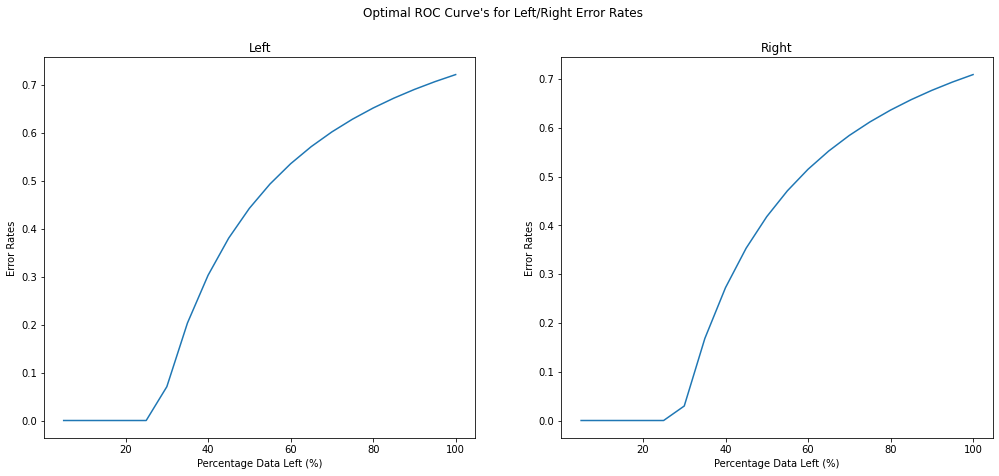

In [58]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(17, 7))
fig.suptitle("Optimal ROC Curve's for Left/Right Error Rates")
x_values = [ratio * 100 for ratio in ratio_pixels]

# Left
left_ax.plot(x_values, left_optimal_roc)
left_ax.set_title("Left")
left_ax.set(xlabel="Percentage Data Left (%)", ylabel="Error Rates")

# Right
right_ax.plot(x_values, right_optimal_roc)
right_ax.set_title("Right")
right_ax.set(xlabel="Percentage Data Left (%)", ylabel="Error Rates")
plt.show()

### ROC Curve for Error Rate (Cumulitive Error Distribution)

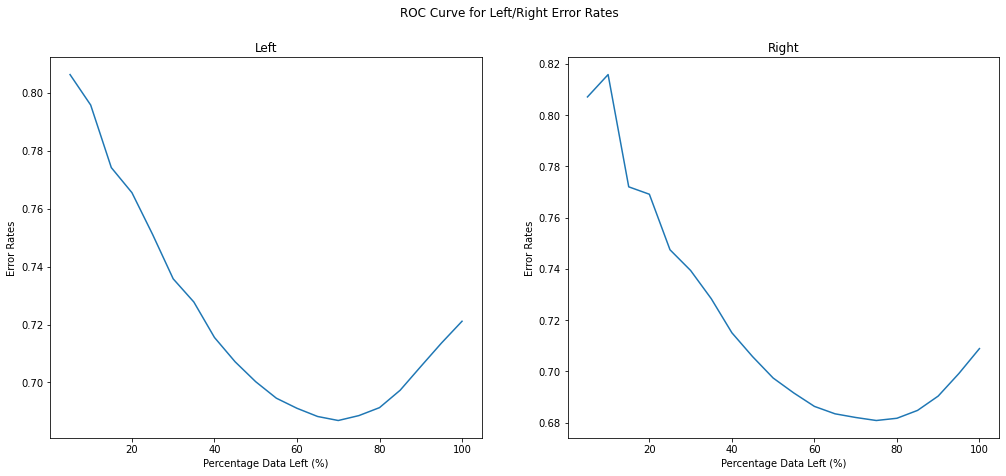

In [59]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(17, 7))
fig.suptitle("ROC Curve for Left/Right Error Rates")
x_values = [ratio * 100 for ratio in ratio_pixels]

# Left
left_ax.plot(x_values, left_roc)
left_ax.set_title("Left")
left_ax.set(xlabel="Percentage Data Left (%)", ylabel="Error Rates")

# Right
right_ax.plot(x_values, right_roc)
right_ax.set_title("Right")
right_ax.set(xlabel="Percentage Data Left (%)", ylabel="Error Rates")
plt.show()

### Ratio of Data Filtered Per Confidence Value

In [60]:
# Confidence values at each interval of cumulitive data
left_conf_at_ratios = []
for ratio in ratio_pixels:
    index = int(left_sorted_conf.shape[0] * ratio)
    left_conf_at_ratios.append(left_sorted_conf[index - 1])

right_conf_at_ratios = []
for ratio in ratio_pixels:
    index = int(right_sorted_conf.shape[0] * ratio)
    right_conf_at_ratios.append(left_sorted_conf[index - 1])

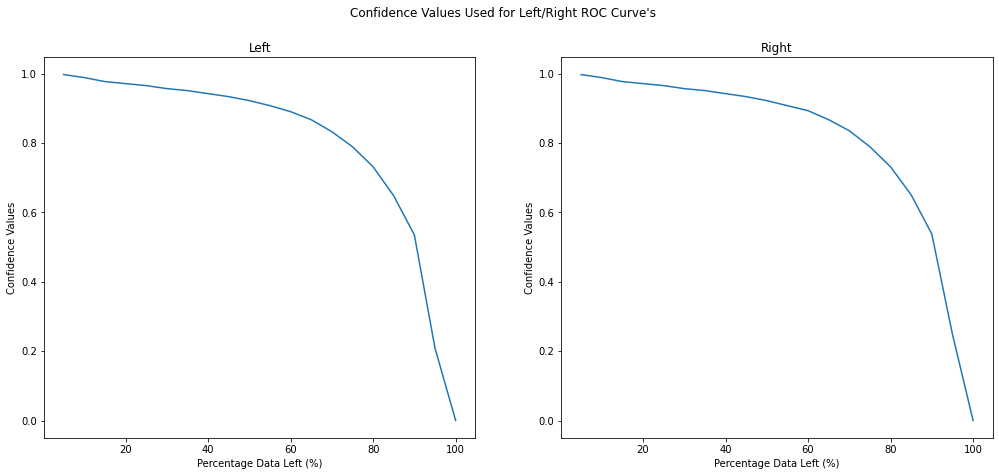

In [61]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(17, 7))
fig.suptitle("Confidence Values Used for Left/Right ROC Curve's")
x_values = [ratio * 100 for ratio in ratio_pixels]
conf_at_ratios = [ratio * 100 for ratio in ratio_pixels]

# Left
left_ax.plot(x_values, left_conf_at_ratios)
left_ax.set_title("Left")
left_ax.set(xlabel="Percentage Data Left (%)", ylabel="Confidence Values")

# Right
right_ax.plot(x_values, right_conf_at_ratios)
right_ax.set_title("Right")
right_ax.set(xlabel="Percentage Data Left (%)", ylabel="Confidence Values")
plt.show()

### Calculate AUC

In [62]:
def calc_auc(roc, optimal_roc):
    auc = np.trapz(roc, dx=1./20)
    optimal_auc = np.trapz(optimal_roc, dx=1./20)
    return auc, optimal_auc

In [63]:
left_auc, left_optimal_auc = calc_auc(left_roc, left_optimal_roc)
right_auc, right_optimal_auc = calc_auc(right_roc, right_optimal_roc)

print("Left Results: ")
print(f"\tTotal Error: {left_mean_error:.3f}, AUC: {left_auc:.3f}, Optimal AUC: {left_optimal_auc:.3f}")
print("Right Results: ")
print(f"\tTotal Error: {right_mean_error:.3f}, AUC: {right_auc:.3f}, Optimal AUC: {right_optimal_auc:.3f}")

Left Results: 
	Total Error: 0.721, AUC: 0.685, Optimal AUC: 0.365
Right Results: 
	Total Error: 0.709, AUC: 0.681, Optimal AUC: 0.350
